#  Amazon Fine Food Reviews Analysis:

    
=> Predictions:
    
    The purpose of this analysis is to make up a prediction model where we will be able to 
    predict whether a recommendation is positive or negative. In this analysis, we will 
    not focus on the Score, but only the positive/negative sentiment of the recommendation.
    To do so, we will work on Amazon's recommendation dataset, we will build a Term-doc 
    incidence matrix using term frequency and inverse document frequency ponderation.
    When the data is ready, we will load it into predicitve algorithms, mainly naïve Bayesian
    and regression.In the end, we hope to find a "best" model for predicting the
    recommendation's sentiment.

=> Loading the data:
    
   1. In order to load the data, we will use the SQLITE dataset where we will only fetch 
   the Score and the recommendation summary.

   2.As we only want to get the global sentiment of the recommendations (positive or negative), 
     we will purposefully ignore all Scores equal to 3. If the score id above 3, then the
     recommendation wil be set to "postive". Otherwise, it will be set to "negative".

    The data will be split into an training set and a test set with a test set ratio of 0.2

=> Attribute information:
    
    1.Id
    2.Product id
    3.User id
    4.Profile name
    5.Helpful numerator
    6.helpful denominator
    7.Reviews=Positive (4 or 5) and Negative (1 or 2)
    8.Time
    9.Summary
    10.Text

Objective:
    
    We have to find TSNE representation of :
   
   1. Bag of words,
   2. tf-idf,
   3. Avg w2v,
   4. tf-idf w2v 

In [1]:
# Importing Necesssry Packages 

%matplotlib inline
import re
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer



# Using the  table to read data

df=pd.read_csv('Reviews.csv')
df.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
# Filtering only positive and negative reviews.
# Not taking into consideration yhose reviews with score=3

In [2]:
filtered_data=pd.read_csv('Reviews.csv')
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
# Give review with score>3 a positive rating and reviews with a score<3

def partition(x):
    if x<3:
         return 'negative'
    return 'positive'
    
       


In [4]:
# Changing Reviews with score less than 3 to be positive and vice versa

actualScore=filtered_data['Score']
positiveNegative=actualScore.map(partition)
filtered_data['Score']=positiveNegative
filtered_data.shape
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
df.duplicated()
df.head()
 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
# Sorting Data according to ProductId in ascending order

sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True,)


In [7]:
# Deduplication of entries

final=sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'}
                                  ,keep='first',inplace=False)
final.shape

(393933, 10)

In [8]:
(final["Id"].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.29901100176971

=> Observation:

In [9]:
# Always remember that helpfulness num<=helpfulness denominator.

display=pd.read_csv('Reviews.csv')
display

final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
# before starting the next phase of preprocessing 
# let us seee the number of items

print(final.shape)

(393931, 10)


In [11]:
# How many positive and negative reviews are present in our dataset.

final['Score'].value_counts()


positive    336824
negative     57107
Name: Score, dtype: int64

In [12]:
final.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150528,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,positive,1108425600,"Nice cadence, catchy rhymes",In June<br />I saw a charming group<br />of ro...
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
150504,150505,0006641040,A2PTSM496CF40Z,"Jason A. Teeple ""Nobody made a greater mistak...",1,1,positive,1210809600,A classic,Get the movie or sound track and sing along wi...
150503,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,positive,1212278400,Chicken Soup with Rice,A very entertaining rhyming story--cleaver and...


In [ ]:
Text Preprocessing: Stemming, stop-word removal and Lemmatization

In [13]:
=> Now that we have finished deduplication our data requires some preprocessing
before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1.Begin by removing the html tags
2.Remove any punctuations or limited set of special characters like , or . or # etc.
3.Check if the word is made up of english letters and is not alpha-numeric
4.Check to see if the length of the word is greater than 2 
(as it was researched that there is no adjective in 2-letters)
5.Convert the word to lowercase
6.Remove Stopwords
7.Finally Snowball Stemming the word (it was obsereved to be better than Porter
  Stemming)
8.After which we collect the words used to describe positive and negative reviews

SyntaxError: invalid syntax (<ipython-input-13-1d8b771167ac>, line 1)

In [15]:
# find sentences containing HTML tags
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

0
In June<br />I saw a charming group<br />of roses all begin<br />to droop<br />I pepped them up<br />with chicken soup!<br />Sprinkle once<br />sprinkle twice<br />sprinkle chicken soup<br />with rice<br /><br />This is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn't nearly as good as some of Sendak's other books (like Where the Wild Things are or Pierre: The Boy Who Didn't Care), but it still carries his unique brand of charm.


In [16]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special_characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Saurabh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{'through', "needn't", 'during', 'ma', 'did', 'they', 'is', 'don', "mightn't", 'his', "aren't", 'again', "weren't", 'now', 'this', 'she', 'above', 'should', 'then', 'y', 'both', 'such', 'same', 'haven', "mustn't", 'as', 'i', 'shouldn', 'than', 'myself', 'me', 'their', 'most', 'doesn', 'needn', 'any', 'to', 'him', "that'll", 'will', 'ourselves', 'from', 're', 'about', 'not', 'be', 'below', 'some', 'won', 'ain', 'so', 'its', "don't", "should've", 'where', 'by', 'of', 'why', 'that', 've', 'you', 'was', 'down', 'himself', "hadn't", 'ours', "isn't", 'until', 'mightn', 'while', 'hasn', 'wouldn', 'aren', 'our', 'whom', 'an', 'if', "haven't", 'up', 'didn', "doesn't", 'themselves', 'very', 'these', 'when', 'few', 't', 'it', 'had', 'm', 'those', 'couldn', 'have', 'hers', "shan't", 'after', "you'd", 'can', 'with', 'own', 'yours', 'o', 'y

In [17]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s)            #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [18]:
final['CleanedText']=final_string  #adding a column of CleanedText which displays the
                                    #data after pre-processing of the review 

# An Introduction to Bag Of Words =>

In [ ]:
We convert text to a numerical representation called a feature vector.
A feature vector can be as simple as a list of numbers.

The bag-of-words model is one of the feature extraction algorithms for text.

# Classification Of Bag Of Words Using Tsne 

In [14]:
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final['Text'].values)

In [25]:
type(final_counts)

scipy.sparse.csr.csr_matrix

In [26]:
final_counts.get_shape()

(393931, 120251)

In [27]:
print(df.shape)

(568454, 10)


     Dim_1     Dim_2     label
0 -8.48749  -3.44611  positive
1 -2.49999   -5.7627  positive
2  1.72465   4.95329  positive
3  4.23387 -0.756875  positive
4  3.36928   3.15518  positive
(1000, 3)
['positive' 'negative']


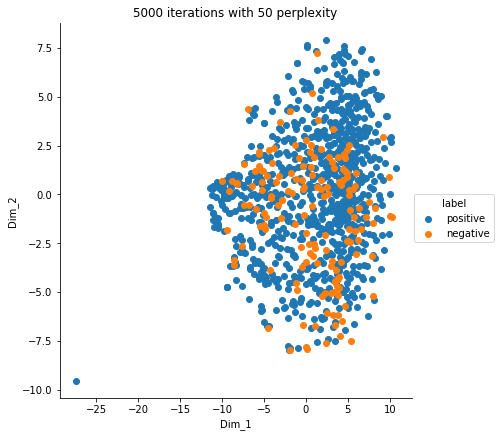

In [29]:
from sklearn.manifold import TSNE
data_1000 = final_counts[0:1000,:]
top_1000 = data_1000.toarray()
labels = final['Score']
labels_1000 = labels[0:1000]

model = TSNE(n_components=2,random_state=0,perplexity=50,n_iter=5000)
tsne_data = model.fit_transform(top_1000)
 
# creating a new data frame which help us in ploting the result data

tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","label"))

print(tsne_df.head())
print(tsne_df.shape)
print(tsne_df['label'].unique())

sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, "Dim_1","Dim_2")
.add_legend()
plt.title("5000 iterations with 50 perplexity")
plt.show()


In [ ]:
Observation=> when we take 1000 data points,perplexity=50 and iterations=5000

Here,we seen that the all fo the my data points are overlap each other but in 
some are there no overlaps and we clearly seen that positive data there.
But in some parts the data are overlaps are we not distinguish 
easily that data into positive or negative.

     Dim_1    Dim_2     label
0 -9.07576  16.4308  positive
1 -6.34227 -1.47371  positive
2 -11.3146 -2.79909  positive
3  6.76442 -6.39409  positive
4 -7.89755 -12.0329  positive
(2000, 3)
['positive' 'negative']


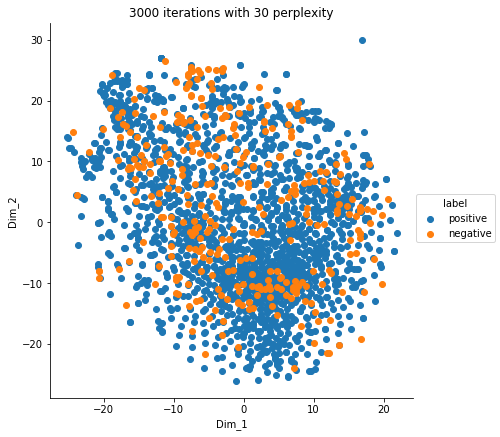

In [30]:
from sklearn.manifold import TSNE
data_2000 = final_counts[0:2000,:]
top_2000 = data_2000.toarray()
labels = final['Score']
labels_2000 = labels[0:2000]

model = TSNE(n_components=2,random_state=0,perplexity=30,n_iter=3000)
tsne_data = model.fit_transform(top_2000)
 
# creating a new data frame which help us in ploting the result data

tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","label"))

print(tsne_df.head())
print(tsne_df.shape)
print(tsne_df['label'].unique())

sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, "Dim_1","Dim_2")
.add_legend()
plt.title("3000 iterations with 30 perplexity")
plt.show()

In [ ]:
Observation => When we use 2000 data points,perplexity=30 and iterations=3000

Here,we seen that the all fo the my data points are overlap each other but in
some are there no overlaps and we clearly seen that positive data there.
But in some parts the data are overlaps are we not distinguish 
easily that data into positive or negative.



#  An introduction to TF-IDF =>

In [ ]:
TF-IDF stands for “Term Frequenct — Inverse Data Frequency”.

Term Frequency (tf): gives us the frequency of the word in each document in the corpus. 
It is the ratio of number of times the word appears in a document compared to the 
total number of words in that document.It increases as the number of occurrences 
of that word within the document increases. Each document has its own tf.

Inverse Data Frequency (idf)=>

Used to calculate the weight of rare words across all documents in the corpus.
The words that occur rarely in the corpus have a high IDF score. It is given by
the equation below.

# Classification of TF-IDF using Tsne

In [19]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final['Text'].values)

In [20]:
final_tf_idf.get_shape()

(393931, 3086788)

In [21]:
features = tf_idf_vect.get_feature_names()
len(features)

3086788

In [22]:
features[100000:100010]

['agreeable but',
 'agreeable crunch',
 'agreeable due',
 'agreeable enough',
 'agreeable flavor',
 'agreeable food',
 'agreeable for',
 'agreeable from',
 'agreeable had',
 'agreeable if']

In [23]:
# covnert a row in saprsematrix to a numpy array

print(final_tf_idf[3,:].toarray()[0])


[0. 0. 0. ... 0. 0. 0.]


In [24]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding
        feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)

In [25]:
top_tfidf

,feature,tfidf
0,learn,0.216779
1,handmotions,0.206926
2,the handmotions,0.206926
3,handmotions which,0.206926
4,invent for,0.206926
5,each poem,0.206926
6,which invent,0.206926
7,poems throughout,0.206926
8,their months,0.200565
9,learn their,0.200565


In [29]:
final_tf_idf = tf_idf_vect.fit_transform(final['Text'].values)

     Dim_1    Dim_2     label
0  5.61234  -20.056  positive
1 -4.34718 -2.25545  positive
2 -8.88878 -5.34194  positive
3  6.50478  8.48405  positive
4  1.19587  11.8736  positive
(2000, 3)
['positive' 'negative']


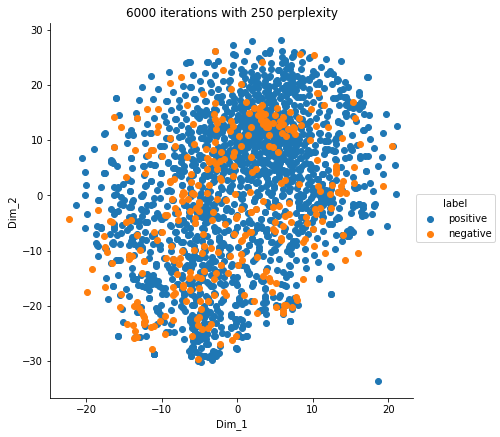

In [32]:
from sklearn.manifold import TSNE
data_2000 = final_counts[0:2000,:]
top_2000 = data_2000.toarray()
labels = final['Score']
labels_2000 = labels[0:2000]
final_tf_idf = tf_idf_vect.fit_transform(final['Text'].values)


model = TSNE(n_components=2, learning_rate = 500, random_state=0,n_iter=6000,perplexity=30)
tsne_data = model.fit_transform(top_2000)
 
# creating a new data frame which help us in ploting the result data

tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","label"))

print(tsne_df.head())
print(tsne_df.shape)
print(tsne_df['label'].unique())

sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, "Dim_1","Dim_2").add_legend()
plt.title("6000 iterations with 250 perplexity")
plt.show()


In [ ]:
Observation=> When we take 1000 data points,perpexity=250 and iterations=6000

Here we seen that all positive and negative data points are overlapping each other so
we cannot easily distinguish the positive and negative data points but here we also 
seen that a single positive point is shown far from all the points

      Dim_1    Dim_2     label
0   3.75879 -9.58516  positive
1   3.58767  3.95223  positive
2    4.7222    2.884  positive
3  -4.51457  4.78176  positive
4 -0.517519  6.14237  positive
(2000, 3)
['positive' 'negative']


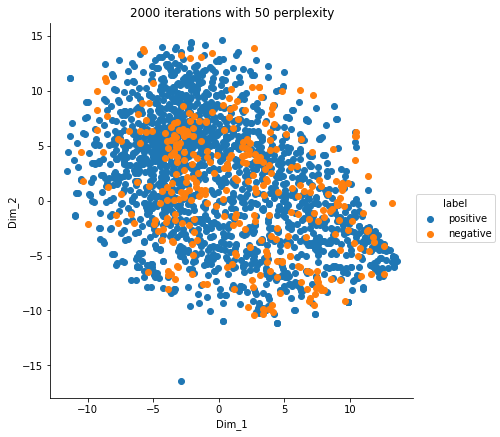

In [40]:
from sklearn.manifold import TSNE
data_2000 = final_counts[0:2000,:]
top_2000 = data_2000.toarray()
labels = final['Score']
labels_2000 = labels[0:2000]

model = TSNE(n_components=2, learning_rate = 500, random_state=0,n_iter=2000
             ,perplexity=50)
tsne_data = model.fit_transform(top_2000)
 
# creating a new data frame which help us in ploting the result data

tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","label"))

print(tsne_df.head())
print(tsne_df.shape)
print(tsne_df['label'].unique())

sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, "Dim_1","Dim_2")
.add_legend()
plt.title("2000 iterations with 50 perplexity")
plt.show()


In [ ]:
Observation=> When we take 2000 data pointsperpexity=50 and iterations 2000

Here we seen that all positive and negative data points are overlapping each other
so we cannot easily distinguish the positive and negative data points but here we 
also seen that a single positive point is shown far from all the points

#  Word2vec =>

In [ ]:
word2vec is an algorithm for constructing vector representations of words, also known 
as word embeddings. The vector for each word is a semantic description of how that 
word is used in context, so two words that are used similarly in text will get 
similar vector represenations.Once you map words into vector space, you can then 
use vector math to find words that have similar semantics.

# Using Google News Word2Vectors

In [42]:
import re
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',
                                          binary=True)

In [44]:
model.wv.similarity('woman', 'man')

C:\Users\Saurabh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
C:\Users\Saurabh\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.76640123

In [45]:
model.wv.most_similar('tasty') 


C:\Users\Saurabh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
C:\Users\Saurabh\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('delicious', 0.8730390071868896),
 ('scrumptious', 0.8007042407989502),
 ('yummy', 0.7856923937797546),
 ('flavorful', 0.7420163154602051),
 ('delectable', 0.7385421991348267),
 ('juicy_flavorful', 0.7114803791046143),
 ('appetizing', 0.7017217874526978),
 ('crunchy_salty', 0.7012301087379456),
 ('flavourful', 0.6912213563919067),
 ('flavoursome', 0.6857703328132629)]

In [46]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

In [47]:
print(final['Text'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

In June<br />I saw a charming group<br />of roses all begin<br />to droop<br />I pepped them up<br />with chicken soup!<br />Sprinkle once<br />sprinkle twice<br />sprinkle chicken soup<br />with rice<br /><br />This is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn't nearly as good as some of Sendak's other books (like Where the Wild Things are or Pierre: The Boy Who Didn't Care), but it still carries his unique brand of charm.
*****************************************************************
['in', 'june', 'i', 'saw', 'a', 'charming', 'group', 'of', 'roses', 'all', 'begin', 'to', 'droop', 'i', 'pepped', 'them', 'up', 'with', 'chicken', 'soup', 'sprinkle', 'once', 'sprinkle', 'twice', 'sprinkle', 'chicken', 'soup', 'with', 'rice', 'this', 'is', 'a', 'great', 'book', 'to', 'teach', 'children', 'the', 'months', 'of', 'the', 'year', 'the', 'repetition', '

In [48]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, 
                                 workers=4) 

In [49]:
words = list(w2v_model.wv.vocab)
print(len(words))

35140


In [50]:
w2v_model.wv.most_similar('tasty')

C:\Users\Saurabh\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('tastey', 0.885934054851532),
 ('satisfying', 0.8553158044815063),
 ('yummy', 0.8509554862976074),
 ('filling', 0.8147091865539551),
 ('delicious', 0.8125235438346863),
 ('flavorful', 0.7986399531364441),
 ('tasteful', 0.7899627089500427),
 ('addicting', 0.7626280784606934),
 ('versatile', 0.7522609233856201),
 ('delish', 0.7506635785102844)]

In [51]:
count_vect_feat = count_vect.get_feature_names() # list of words in the BoW
count_vect_feat.index('tasty')
print(count_vect_feat[64055])

keylime


     Dim_1     Dim_2     label
0 -8.48749  -3.44611  positive
1 -2.49999   -5.7627  positive
2  1.72465   4.95329  positive
3  4.23387 -0.756875  positive
4  3.36928   3.15518  positive
(1000, 3)
['positive' 'negative']


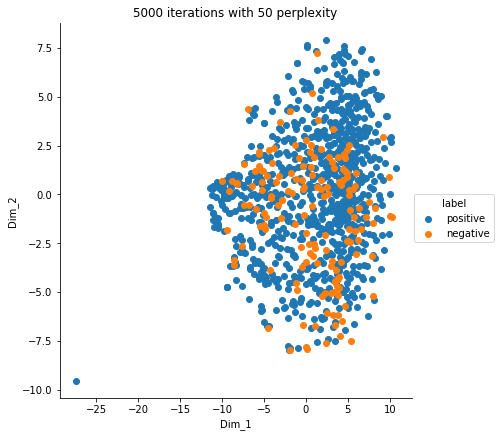

In [70]:
from sklearn.manifold import TSNE
data_1000 = final_counts[0:1000,:]
top_1000 = data_1000.toarray()
labels = final['Score']
labels_1000 = labels[0:1000]

model = TSNE(n_components=2,random_state=0,perplexity=50,n_iter=5000)
tsne_data = model.fit_transform(top_1000)
 
# creating a new data frame which help us in ploting the result data

tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","label"))

print(tsne_df.head())
print(tsne_df.shape)
print(tsne_df['label'].unique())

sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, "Dim_1","Dim_2")
.add_legend()
plt.title("5000 iterations with 50 perplexity")
plt.show()

In [ ]:
# Observation=>When we take 1000 data points,perpexity=50 and iterations 5000

Here we seen that all positive and negative data points are overlapping each other 
so we cannot easily distinguish the positive and negative data points but here we 
also seen that a single positive point is shown far from all the points

#  Classification of avg word2vec using tsne

In [55]:
# average Word2Vec
# compute average word2vec for each review
sent_vectors = [];            # the avg-w2v for each sentence/review is stored in 
                              #this list
for sent in list_of_sent:     # for each review/sentence
    sent_vec = np.zeros(50)   # as word vectors are of zero length
    cnt_words =0;             # num of words with a valid vector in the sentence/review
    for word in sent:         # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

C:\Users\Saurabh\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


393931
50


      Dim_1    Dim_2     label
0   16.5019 -15.0289  positive
1  0.880632 -6.49288  positive
2  -8.43573  -11.717  positive
3  -2.18549  7.97556  positive
4  -6.28254  16.4617  positive
(1000, 3)
['positive' 'negative']


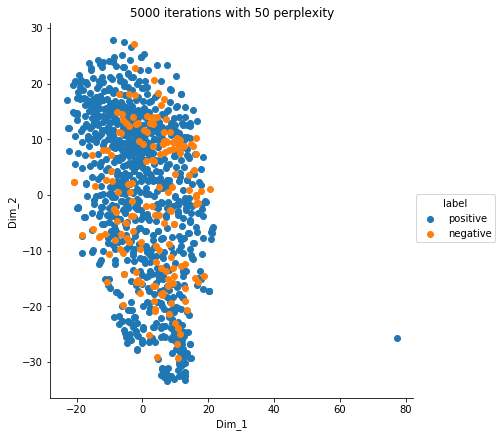

In [71]:
from sklearn.manifold import TSNE
data_1000 = final_counts[0:1000,:]
top_1000 = data_1000.toarray()
labels = final['Score']
labels_1000 = labels[0:1000]

model = TSNE(n_components=2,random_state=0,perplexity=20,n_iter=1000)
tsne_data = model.fit_transform(top_1000)
 
# creating a new data frame which help us in ploting the result data

tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","label"))

print(tsne_df.head())
print(tsne_df.shape)
print(tsne_df['label'].unique())

sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, "Dim_1","Dim_2")
.add_legend()
plt.title("5000 iterations with 50 perplexity")
plt.show()

In [ ]:
Observation => When we take 1000 data pointsperpexity=50 and iterations 5000

Here we seen that all positive and negative data points are overlapping each other 
so we cannot easily distinguish the positive and negative data points but here we 
also seen that a single positive point is shown far from all the points

# TF-IDF Weighted Word2Vec Using  TSNE Visulaization

In [ ]:
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this 
                        #list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
            
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

      Dim_1    Dim_2     label
0   16.5019 -15.0289  positive
1  0.880632 -6.49288  positive
2  -8.43573  -11.717  positive
3  -2.18549  7.97556  positive
4  -6.28254  16.4617  positive
(1000, 3)
['positive' 'negative']


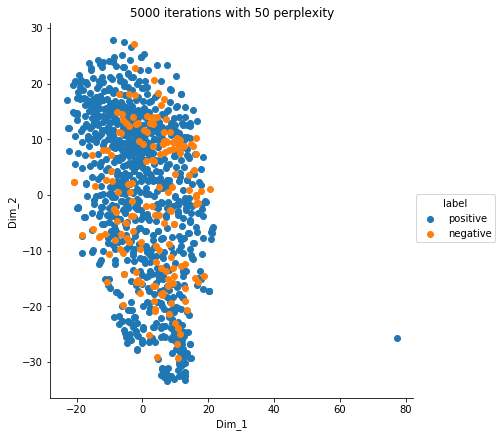

In [73]:
from sklearn.manifold import TSNE
data_1000 = final_counts[0:1000,:]
top_1000 = data_1000.toarray()
labels = final['Score']
labels_1000 = labels[0:1000]

model = TSNE(n_components=2,random_state=0,perplexity=20,n_iter=1000)
tsne_data = model.fit_transform(top_1000)
 
# creating a new data frame which help us in ploting the result data

tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","label"))

print(tsne_df.head())
print(tsne_df.shape)
print(tsne_df['label'].unique())

sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, "Dim_1","Dim_2")
.add_legend()
plt.title("5000 iterations with 50 perplexity")
plt.show()

In [ ]:
Observation=>When we take 1000 data pointsperpexity=50 and iterations 2000

Here we seen that all positive and negative data points are overlapping each other
so we cannot easily distinguish the positive and negative data points but here we 
also seen that a single positive point is shown far from all the points



# Conclusion:

In [ ]:
In this assignment we see that how we change the score, text values into numeric and
make the text(reviews) data into numeric data. So the conclusion driven from this
assignment is that we can easily use numeric data to make the plots using tsne in 
this assignment. We can easily figure out the positive eand negative reviews using
the tsne plots. 